<a href="https://colab.research.google.com/github/cschwi/ds_job_app/blob/main/EMNIST_Midterm_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognition of Handwritten Letters

In [ ]:
import torch
import torchvision

# Setting seed for reproducibility
torch.manual_seed(123987)



```
# This is formatted as code
```

## Loading EMNIST data


In [ ]:
emnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    # There was more here
])

In [ ]:
## Loading EMNIST data
## PyTorch uses the Dataset class from torch.utils.data to handle access to datasets
data_train = torchvision.datasets.EMNIST( # Training set
    root='./data/',
    train=True,
    download=True,
    transform=emnist_transform,  # rotates images and
    split='letters'
)

data_test = torchvision.datasets.EMNIST( # Testing set
    root='./data/',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    split='letters'
)

100%|██████████| 562M/562M [00:42<00:00, 13.2MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


Let us examine the sizes of the two datasets as well as the shape of their elements, as we did in the lab.

In [ ]:
print(f"Number of training images: {len(data_train)}")
print(f"Number of test images:     {len(data_test)}")
print()
print("Each data element is an (image, label) pair.")
print(f"Shape of each image: {data_train[0][0].shape}")

Number of training images: 124800
Number of test images:     20800

Each data element is an (image, label) pair.
Shape of each image: torch.Size([1, 28, 28])


To get a better idea of what the elements in a dataset look like, let us plot several EMNIST images.

In [ ]:
import matplotlib.pyplot as plt

# Plotting function.  The argument 'images' is a tensor of
# the form [1,28,28].  For plotting, we need flattened tensor
# of the shape [28,28].  Hence, we use 'images[i][0]' in the
# call of 'plt.imshow' below.
def plot_data(images, labels):
    cols, rows = 3, 3
    for i in range(cols * rows):
        plt.subplot(cols, rows, i + 1)
        plt.tight_layout()
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
    plt.show()

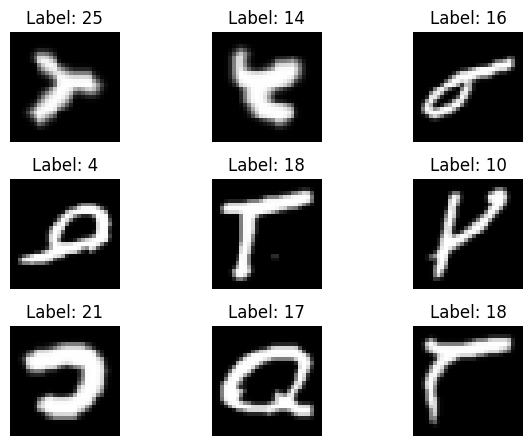

In [ ]:
# Get a list of 9 images and their labels from the train data
# starting from the index 'start_idx'
start_idx = 500 #10994 59915

data_subset = [data_train[i] for i in range(start_idx, start_idx + 9)]
images, labels = zip(*data_subset)

plot_data(images, labels)

We often need to draw random subsets of the training and testing data, known as batches. To help managing loads of segments of the datasets, PyTorch has the convenient `DataLoader` class.

In [ ]:
print(f"Number of labels is {len(labels)}")

Number of labels is 9


Shape of images is: torch.Size([64, 1, 28, 28])
Shape of labels is: torch.Size([64])



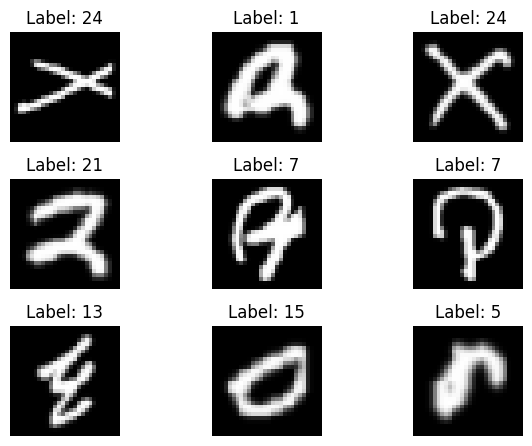

In [ ]:
# Batch sizes for training and evaluation
batch_size_train = 64
batch_size_test  = 1000

# We can use PyTorch dataloaders to get batches from datasets
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
loader_test  = torch.utils.data.DataLoader(data_test,  batch_size=batch_size_test,  shuffle=False)

# Create an iterator and draw the next batch
images, labels = next(iter(loader_train))
print(f"Shape of images is: {images.shape}")
print(f"Shape of labels is: {labels.shape}")
print()
plot_data(images, labels)

## Architecture
Next, we create the deep neural network model to be used for the digit recognition.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size=28 * 28, hidden_sizes = (128,128), output_size=27):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Use GPU for training if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = Net().to(device)

In [ ]:
# Example of the output produced by the model
with torch.no_grad():
    print(model(images[0].to(device)).cpu().numpy().flatten().round(4))

[ 0.1101 -0.0218  0.0312 -0.0367  0.045   0.0758 -0.0259 -0.0782  0.0903
  0.0026  0.1293 -0.0256 -0.0302  0.0643  0.0479  0.0333 -0.012   0.0265
 -0.0413  0.0093  0.0544 -0.0341 -0.01    0.0813 -0.0822  0.0659 -0.1034]


## Training

Now that we have our model, we can specify the training parameters.

In [ ]:
# Use the cross entropy loss for the multi-class classification
criterion = nn.CrossEntropyLoss()

# SGD optimization hyperparameters
learning_rate = 0.1
momentum = 0.7

# Optimize using the Stochastic Gradient Descent
# with the given learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Number of epochs for training
num_epochs = 5

In [ ]:
# Train 'model' through batches in one epoch using the 'criterion' loss function,
# on the training dataset produced by the 'loader'.
def train(model, criterion, optimizer, loader, epoch):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch: {epoch+1}/{num_epochs}   Training loss: {running_loss/len(loader) :.6f}")


In [ ]:
# Time to train the net!
for epoch in range(num_epochs):
    train(model, criterion, optimizer, loader_train, epoch)

Epoch: 1/5   Training loss: 0.723555
Epoch: 2/5   Training loss: 0.384334
Epoch: 3/5   Training loss: 0.325614
Epoch: 4/5   Training loss: 0.291000
Epoch: 5/5   Training loss: 0.268976


## Testing
Let us see is the model is capable of recognizing the digits.

In [ ]:
# Individual output
images, labels = next(iter(loader_test))

with torch.no_grad():
    images,labels = images.to(device), labels.to(device)
    outputs = model(images)

What does the output of our model look like?

In [ ]:
import numpy as np

probit = F.softmax(outputs[0], dim=0).cpu().numpy()
argmax = np.argmax(probit)

print("Probabilities of the 27 classes:\n")
for i in range(27):
    arrow = "<---" if i == argmax else ""
    print(f"{i}: {probit[i]:.6f} {arrow}")

print()
print(f"Letter corresponding to {argmax} with confidence {probit[argmax] * 100. :.2f}")

Probabilities of the 27 classes:

0: 0.000000 
1: 0.993361 <---
2: 0.000000 
3: 0.000180 
4: 0.000000 
5: 0.001815 
6: 0.000001 
7: 0.000778 
8: 0.000018 
9: 0.000008 
10: 0.000000 
11: 0.000030 
12: 0.000000 
13: 0.000004 
14: 0.001994 
15: 0.000001 
16: 0.000000 
17: 0.000337 
18: 0.001013 
19: 0.000025 
20: 0.000000 
21: 0.000162 
22: 0.000000 
23: 0.000010 
24: 0.000220 
25: 0.000000 
26: 0.000040 

Letter corresponding to 1 with confidence 99.34


Here are some examples of digits together with their inferred classes.

[(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]


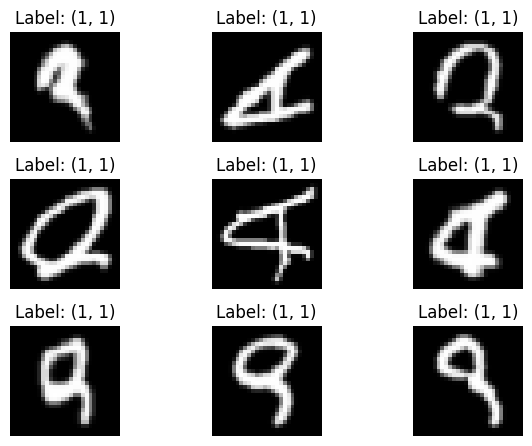

In [ ]:
# Let's get a batch of 9 images staring from index 'start_idx'
start_idx = 0
plot_batch = torch.utils.data.Subset(data_test, indices=range(start_idx, start_idx + 9))
images, labels = next(iter(torch.utils.data.DataLoader(plot_batch, batch_size=9)))

# Note that torch.max(outputs, dim=1) gives a pair (values, indices) tensors.
# We only need the indices, for these encode our predictions.
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().tolist()
labels    = labels.cpu().tolist()
pairs_lab_pred = list(zip(labels, predicted))
print(pairs_lab_pred)
plot_data(images.cpu(), pairs_lab_pred)


How many digits from the testing data did we get right?

In [ ]:
# Test the model
def test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) # labels.size() is [1000]
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")
    model.train()

In [ ]:
# Print the accuracy of our model
test(model, loader_test)

Accuracy: 89.29%
